In [ ]:
!pip install numba

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numba import cuda

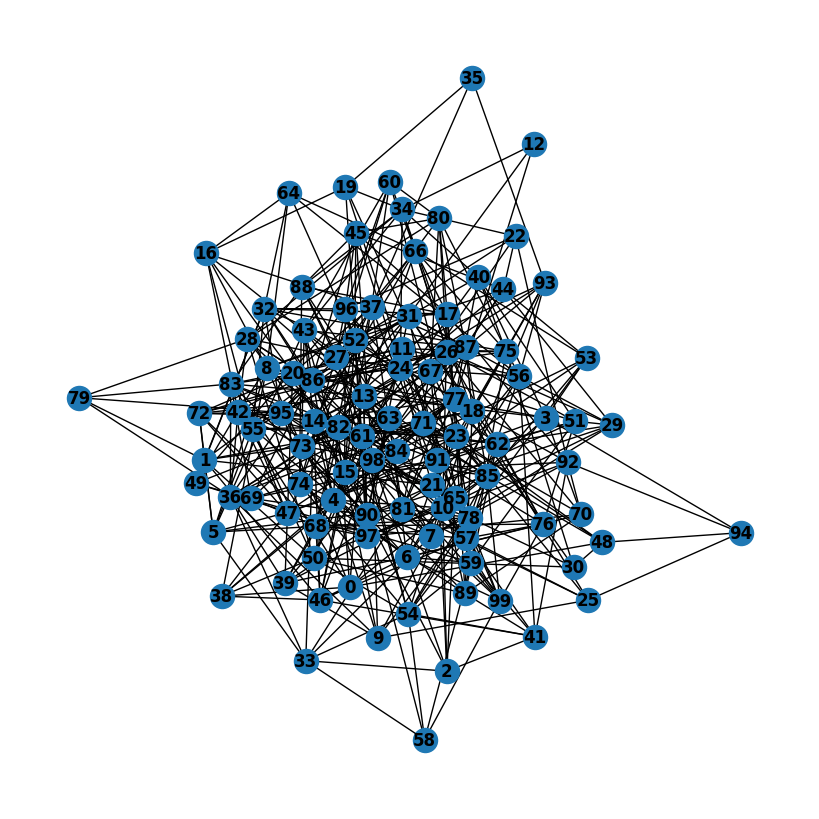

In [ ]:
# Generar un grafo aleatorio
np.random.seed(42)
G = nx.erdos_renyi_graph(100, 0.1)

# Visualizar el grafo
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

# Convertir el grafo en una matriz de adyacencia
adj_matrix = nx.convert_matrix.to_numpy_array(G)

In [ ]:
# Definir el kernel de BFS en CUDA
@cuda.jit
def bfs_kernel(queue, visited, result, graph, start):
    while queue.shape[0] > 0:
        current = queue[0]
        queue = queue[1:]

        if not visited[current]:
            visited[current] = True
            result[visited.sum() - 1] = current  # Update result array at the correct index

            for neighbor in range(graph.shape[0]):
                if graph[current, neighbor] == 1 and not visited[neighbor]:
                    queue = np.append(queue, neighbor)

In [ ]:
# Definir la función de BFS en CUDA
def bfs_cuda(graph, start):
    queue = np.array([start], dtype=np.int32)
    visited = np.zeros(graph.shape[0], dtype=np.bool_)
    result = np.zeros(graph.shape[0], dtype=np.int32)  # Fixed-size result array

    d_queue = cuda.to_device(queue)
    d_visited = cuda.to_device(visited)
    d_result = cuda.to_device(result)
    d_graph = cuda.to_device(graph)

    grid_dim = (1, 1)
    block_dim = (1, 1)

    bfs_kernel[grid_dim, block_dim](d_queue, d_visited, d_result, d_graph, start)

    d_result.copy_to_host(result)
    return result[result != 0]

In [ ]:
# Definir la función de DFS en CUDA
@cuda.jit
def bfs_kernel(queue, visited, result, graph, start):
    while queue.shape[0] > 0:
        current = queue[0]
        queue = queue[1:]

        if not visited[current]:
            visited[current] = True
            result[visited.sum() - 1] = current  # Update result array at the correct index

            for neighbor in range(graph.shape[0]):
                if graph[current, neighbor] == 1 and not visited[neighbor]:
                    queue = np.concatenate((queue, np.array([neighbor], dtype=queue.dtype)))


In [ ]:
# Definir la función de DFS en CUDA
def dfs_cuda(graph, start):
    stack = np.array([start], dtype=np.int32)
    visited = np.zeros(graph.shape[0], dtype=np.bool_)
    result = []

    d_stack = cuda.to_device(stack)
    d_visited = cuda.to_device(visited)
    d_result = cuda.to_device(result)
    d_graph = cuda.to_device(graph)

    grid_dim = (1, 1)
    block_dim = (1, 1)

    dfs_kernel[grid_dim, block_dim](d_stack, d_visited, d_result, d_graph, start)

    d_result.copy_to_host(result)
    return result

In [ ]:
# Ejecutar BFS y DFS en CUDA
start_node = 0
bfs_result = bfs_cuda(adj_matrix, start_node)
dfs_result = dfs_cuda(adj_matrix, start_node)

# Visualizar los resultados
print(f"BFS Result: {bfs_result}")
print(f"DFS Result: {dfs_result}")

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
<ipython-input-5-1ca26f074325>:14: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/usr/local/lib/python3.10/dist-packages/numba/core/untyped_passes.py", line 125, in run_pass
    raise TypeError("Signature mismatch: %d argument types given, "

  queue = np.concatenate((queue, np.array([neighbor], dtype=queue.dtype)))


TypingError: ignored